<a href="https://colab.research.google.com/github/Yanas76/OnlineTickets/blob/master/blocks_order_model_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html


2.3.0+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 20.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Extract data

In [ ]:
import os
import json
import copy

def json_files_to_arrays(folder_path):

    result = []

    for filename in os.listdir(folder_path):
        transformed_data = []

        if filename.endswith('.json'):
            file_path = os.path.join(folder_path, filename)

            with open(file_path, 'r') as file:
                json_data = json.load(file)

                for item in json_data:
                    x1 = item['x1']
                    y1 = item['y1']
                    x2 = item['x2']
                    y2 = item['y2']

                    transformed_data.append([x1, y1, x2, y2])

                if len(transformed_data) > 1:
                  result.append(transformed_data)

    return result

data_folder = '/content/drive/MyDrive/text_blocks_locations'
transformed_data = json_files_to_arrays(data_folder)
print(len(transformed_data))

1928


Generate and visualize dataset

In [ ]:
import math

def rotate_bbox_coordinates(bboxes, angle, origin_point):

    rotated_bboxes = []
    angle_rad = math.radians(angle)
    cos_theta = math.cos(angle_rad)
    sin_theta = math.sin(angle_rad)

    for bbox in bboxes:

        x1, y1, x3, y3 = bbox
        x2 = x3
        y2 = y1
        x4 = x1
        y4 = y3

        translated_x1 = x1 - origin_point[0]
        translated_y1 = y1 - origin_point[1]
        translated_x3 = x3 - origin_point[0]
        translated_y3 = y3 - origin_point[1]

        translated_x2 = x2 - origin_point[0]
        translated_y2 = y2 - origin_point[1]
        translated_x4 = x4 - origin_point[0]
        translated_y4 = y4 - origin_point[1]

        rotated_x1 = translated_x1 * cos_theta - translated_y1 * sin_theta
        rotated_y1 = translated_x1 * sin_theta + translated_y1 * cos_theta
        rotated_x3 = translated_x3 * cos_theta - translated_y3 * sin_theta
        rotated_y3 = translated_x3 * sin_theta + translated_y3 * cos_theta

        rotated_x2 = translated_x2 * cos_theta - translated_y2 * sin_theta
        rotated_y2 = translated_x2 * sin_theta + translated_y2 * cos_theta
        rotated_x4 = translated_x4 * cos_theta - translated_y4 * sin_theta
        rotated_y4 = translated_x4 * sin_theta + translated_y4 * cos_theta

        final_x1 = rotated_x1 + origin_point[0]
        final_y1 = rotated_y1 + origin_point[1]
        final_x3 = rotated_x3 + origin_point[0]
        final_y3 = rotated_y3 + origin_point[1]

        final_x2 = rotated_x2 + origin_point[0]
        final_y2 = rotated_y2 + origin_point[1]
        final_x4 = rotated_x4 + origin_point[0]
        final_y4 = rotated_y4 + origin_point[1]

        rotated_bboxes.append([[final_x1, final_y1], [final_x2, final_y2], [final_x3, final_y3], [final_x4, final_y4]])

    min_x = min(point[0] for bbox in rotated_bboxes for point in bbox)
    min_y = min(point[1] for bbox in rotated_bboxes for point in bbox)

    if min_x < 0:
      for bbox in rotated_bboxes:
         for point in bbox:
            point[0] += abs(min_x)

    if min_y < 0:
      for bbox in rotated_bboxes:
         for point in bbox:
            point[1] += abs(min_y)

    return rotated_bboxes


In [ ]:
import random

def generate_dataset(data, rotated_amount, angle_range):

    dataset = []

    for d in data:

        max_x = max(point[0] for point in d)
        max_y = max(point[1] for point in d)

        for i in range(rotated_amount):

          order = list(range(1, len(d) + 1))
          angle = random.randint(-angle_range, angle_range)
          origin = [random.uniform(0, max_x), random.uniform(0, max_y)]
          rotated = rotate_bbox_coordinates(d, angle, origin)
          swaps = random.randint(0, len(order) // 2)

          for j in range(swaps):

            pos1 = random.randint(0, len(order) - 1)
            pos2 = random.randint(0, len(order) - 1)
            order[pos1], order[pos2] = order[pos2], order[pos1]
            rotated[pos1], rotated[pos2] = rotated[pos2], rotated[pos1]

          dataset.append([rotated, order])

    return dataset


dataset = generate_dataset(transformed_data, 3, 20)

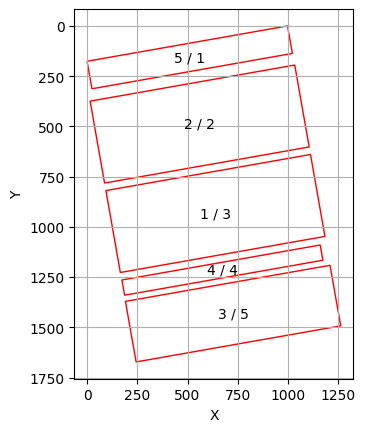

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

def plot_rotated_bbox(rotated_bboxes, order=None):

    fig, ax = plt.subplots()

    for i, bbox in enumerate(rotated_bboxes):

        x1, y1 = bbox[0]
        x2, y2 = bbox[1]
        x3, y3 = bbox[2]
        x4, y4 = bbox[3]

        polygon = Polygon([[x1, y1], [x2, y2], [x3, y3], [x4, y4]], closed=True, fill=None, edgecolor='r')
        ax.add_patch(polygon)

        centroid_x = (x1 + x2 + x3 + x4) / 4
        centroid_y = (y1 + y2 + y3 + y4) / 4

        label = str(i + 1) + " / " + str(order[i])
        ax.text(centroid_x, centroid_y, label, color='black', ha='center', va='center')

    plt.gca().invert_yaxis()
    ax.autoscale_view()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True)
    plt.show()


n = 100
plot_rotated_bbox(dataset[n][0], dataset[n][1])

Generate dataset

In [ ]:
def normalize_row_col_4p(blocks):

  result = []
  x_max = 0
  y_max = 0
  x_min = float('inf')
  y_min = float('inf')

  for block in blocks:
    for point in block:
      if point[0] > x_max: x_max = point[0]
      if point[1] > y_max: y_max = point[1]
      if point[0] < x_min: x_min = point[0]
      if point[1] < y_min: y_min = point[1]

  x_max -= x_min
  y_max -= y_min

  for block in blocks:
    for point in block:
      point[0] -= x_min
      point[1] -= y_min

  for block in blocks:
    normalized_block = []
    for point in block:
      x = point[0] / x_max
      y = point[1] / y_max
      normalized_block.append([x, y])
    result.append(normalized_block)

  return result


In [ ]:
def prepare_data_4p(dataset):

    inputs_list = [example[0] for example in dataset]
    labels_list = [example[1] for example in dataset]
    return inputs_list, labels_list


In [ ]:
import numpy as np

def generate_first_block_dataset(dataset):

    blocks = []
    ground_truths = []
    data_len = len(dataset[0])

    for i in range(data_len):

        bl = dataset[0][i]
        labels = dataset[1][i]
        l = len(labels)

        for j in range(l - 1):

          index = np.argmin(labels)
          truth = [0] * len(labels)
          truth[index] = 1

          bl = normalize_row_col_4p(bl)
          blocks.append(copy.deepcopy(bl))
          ground_truths.append(truth)

          del bl[index]
          del labels[index]

    return blocks, ground_truths

In [ ]:
import copy

d2 = prepare_data_4p(dataset)
blocks, truths = generate_first_block_dataset(copy.deepcopy(d2))

print(len(blocks))
print(len(truths))
print(blocks[100])
print(truths[100])

29781
29781
[[[0.5246220909119609, 0.5679610533522349], [0.9617667470817647, 0.5997144316361454], [0.9498534871144882, 0.7766878033328563], [0.5127088309446846, 0.7449344250489458]], [[0.029275220229663314, 0.5333585687869628], [0.46641987639946697, 0.5651119470708732], [0.45459896728465027, 0.7407134321652838], [0.0174543111148466, 0.7089600538813735]], [[0.015237890655818445, 0.7418853323365755], [0.4523825468256221, 0.773638710620486], [0.4371446561698037, 1.0], [0.0, 0.9682466217160897]], [[0.5628553438301962, 0.0], [1.0, 0.03175337828391047], [0.9847621093441816, 0.25811466766342445], [0.5476174531743778, 0.2263612893795139]], [[0.5740158955288732, 0.5219195151489207], [0.9279577923672643, 0.5476291990766791], [0.9253719684983979, 0.5860420239410813], [0.571430071660007, 0.5603323400133231]], [[0.5454010327153497, 0.25928656783471604], [0.9825456888851534, 0.2910399461186265], [0.967307798229335, 0.5174012354981403], [0.5301631420595312, 0.48564785721423]]]
[0, 1, 0, 0, 0, 0]


## Final

In [ ]:

class FB_Model(nn.Module):

    def __init__(self, input_size, hidden_size):
        super(FB_Model, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()


    def forward(self, blocks):

        x = self.change_format(blocks)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = torch.squeeze(x)
        x = F.softmax(x, dim=0)

        return x


    def change_format(self, blocks):

        x = []
        e = 0.0001
        for b in blocks:
          x.append([b[0][0] + e, b[1][0] + e, b[2][0] + e, b[3][0] + e, b[0][1] + e, b[1][1] + e, b[2][1] + e, b[3][1]+ e])

        x = torch.tensor(x, dtype=torch.float32)
        return x


In [ ]:

def train(dataset, num_epochs=30, lr=0.01):

    input_size = 8
    hidden_size = 64

    model = FB_Model(input_size, hidden_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    blocks, labels = dataset
    previous_loss = float('inf')

    for epoch in range(num_epochs + 1):

        model.train()
        total_loss = 0.0

        for i in range(len(blocks)):

            b = blocks[i]
            l = torch.tensor(labels[i], dtype=torch.float)
            output = model(b)

            loss = criterion(output, l)
            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        average_loss = total_loss / len(blocks)

        if average_loss == previous_loss:
            print(f'Epoch {epoch}, Loss: {average_loss}')
            print("Loss doesn`t change! Stopping!")
            break

        previous_loss = average_loss

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {average_loss}')

    return model

n = 200
model = train((blocks[:n], truths[:n]))

Epoch 0, Loss: 1.0867409846186638
Epoch 10, Loss: 0.8809674802422524
Epoch 20, Loss: 0.8799520182609558
Epoch 30, Loss: 0.8797826799750328


In [ ]:
def reorder_objects(objects, positions):

    combined = zip(objects, positions)
    sorted_combined = sorted(combined, key=lambda x: x[1])
    reordered_objects = [item[0] for item in sorted_combined]

    return reordered_objects

In [ ]:
def connect_f(blocks, model):

    order = []
    while len(blocks) > 1:

        bl = normalize_row_col_4p(copy.deepcopy(blocks))
        probabilities = model(bl).detach().numpy()
        i = np.argmax(probabilities)
        order.append(blocks[i])
        del blocks[i]

    order.append(blocks[0])
    return order


[[0.04, 0.25], [0.98, 0.26], [0.98, 0.31], [0.04, 0.3]]
[[0.01, 0.76], [0.98, 0.77], [0.97, 1.0], [0.0, 0.99]]
[[0.07, 0.0], [0.87, 0.01], [0.86, 0.05], [0.07, 0.04]]
[[0.02, 0.51], [0.98, 0.52], [0.98, 0.75], [0.01, 0.74]]
[[0.02, 0.32], [0.99, 0.32], [0.99, 0.49], [0.02, 0.48]]
[[0.03, 0.05], [1.0, 0.06], [0.99, 0.24], [0.03, 0.23]]

Ground truth:                                                          Model output:
[[0.07, 0.0], [0.87, 0.01], [0.86, 0.05], [0.07, 0.04]]                [[0.07, 0.0], [0.87, 0.01], [0.86, 0.05], [0.07, 0.04]]
[[0.03, 0.05], [1.0, 0.06], [0.99, 0.24], [0.03, 0.23]]                [[0.03, 0.05], [1.0, 0.06], [0.99, 0.24], [0.03, 0.23]]
[[0.04, 0.25], [0.98, 0.26], [0.98, 0.31], [0.04, 0.3]]                [[0.04, 0.25], [0.98, 0.26], [0.98, 0.31], [0.04, 0.3]]
[[0.02, 0.32], [0.99, 0.32], [0.99, 0.49], [0.02, 0.48]]               [[0.02, 0.32], [0.99, 0.32], [0.99, 0.49], [0.02, 0.48]]
[[0.02, 0.51], [0.98, 0.52], [0.98, 0.75], [0.01, 0.74]]            

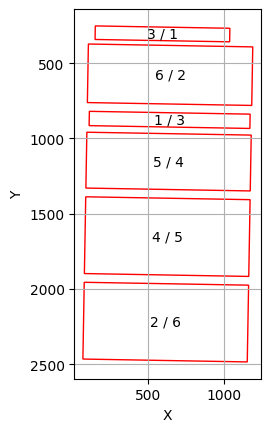

In [ ]:
import copy

def get_c(blocks):
    return [[round(p[0], 2), round(p[1], 2)] for p in blocks]

def print_unordered_blocks(nodes):

    for node in nodes:
        print(get_c(node))
    print()

def print_comparison(truth, result, column_width=70):

    print(f"{'Ground truth:':<{column_width}} Model output:")
    for t, r in zip(truth, result):
        print(f"{str(get_c(t)):<{column_width}} {str(get_c(r))}")
    print()

def reorder_blocks(n, dataset, model):

    nodes_f = normalize_row_col_4p(copy.deepcopy(dataset[n][0]))
    result = connect_f(copy.deepcopy(nodes_f), model)
    truth = reorder_objects(copy.deepcopy(nodes_f), dataset[n][1])

    print_unordered_blocks(nodes_f)
    print_comparison(truth, result)
    plot_rotated_bbox(dataset[n][0], dataset[n][1])

n = 200
reorder_blocks(n, dataset, model)